<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA - Desafío 4
### Alumna Qualindi Noelia - Cohorte 14

In [1]:
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
import fasttext
import fasttext.util
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
import pandas as pd

In [ ]:
!pip install gdown

In [2]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [3]:
# Configuraciones
max_len = 30
MAX_VOCAB_SIZE = 10000
n_units = 128  # Número de unidades LSTM
batch_size = 32
epochs = 50

chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []

def clean_text(txt):
    txt = txt.lower()    
    txt = txt.replace("\'d", " had")
    txt = txt.replace("\'s", " is")
    txt = txt.replace("\'m", " am")
    txt = txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)
    
    return txt

### Dataframe

In [ ]:
import json
with open('data_volunteers.json') as f:
    data = json.load(f)

data[0].keys()

In [5]:
for line in data:
    for i in range(len(line['dialog'])-1):
        # Vamos separando el texto en "preguntas" (chat_in) y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out
        
        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 5985


In [7]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

## 1 - Preprocesamiento 

Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Tokenización de los datos de entrada
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq=input_tokenizer.texts_to_sequences(input_sentences)

word2idx_input = input_tokenizer.word_index

# Cantidad de palabras en el vocabulario
print("La cantidad de palabras en el Vocabulario de Entrada es:", len(word2idx_input))
word2idx_input

La cantidad de palabras en el Vocabulario de Entrada es: 1783


{'i': 1,
 'you': 2,
 'do': 3,
 'what': 4,
 'a': 5,
 'am': 6,
 'to': 7,
 'are': 8,
 'for': 9,
 'is': 10,
 'how': 11,
 'hi': 12,
 'like': 13,
 'living': 14,
 'love': 15,
 'have': 16,
 'not': 17,
 'that': 18,
 'hello': 19,
 'ok': 20,
 'oh': 21,
 'your': 22,
 'read': 23,
 'good': 24,
 'yes': 25,
 'the': 26,
 'it': 27,
 'no': 28,
 'any': 29,
 'work': 30,
 'in': 31,
 'u': 32,
 'me': 33,
 'my': 34,
 'about': 35,
 'and': 36,
 'from': 37,
 'of': 38,
 'go': 39,
 'play': 40,
 'so': 41,
 'today': 42,
 'too': 43,
 'hobbies': 44,
 'fine': 45,
 'nice': 46,
 'name': 47,
 'where': 48,
 'there': 49,
 'hey': 50,
 'doing': 51,
 'know': 52,
 'cool': 53,
 'bye': 54,
 'see': 55,
 'great': 56,
 'favorite': 57,
 'well': 58,
 'sure': 59,
 'old': 60,
 'games': 61,
 'beach': 62,
 'pets': 63,
 'why': 64,
 'at': 65,
 'sorry': 66,
 'nothing': 67,
 'mean': 68,
 'lot': 69,
 'fun': 70,
 'live': 71,
 'okay': 72,
 'thanks': 73,
 'also': 74,
 'can': 75,
 'student': 76,
 'city': 77,
 'vegan': 78,
 't': 79,
 'video': 80,
 '

In [9]:
# Secuencia más larga de entrada
max_input_len_seq=max(len(seq) for seq in input_integer_seq)
print("La secuencia de entrada más larga es:", max_input_len_seq)

La secuencia de entrada más larga es: 9


In [10]:
# Tokenización de los datos de salida
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>","<eos>"] + output_sentences)

output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)

# Diccionario word-idx para salidas
word2idx_output = output_tokenizer.word_index

# Cantidad de palabras en el vocabulario
print("La cantidad de palabras en el Vocabulario de Salida es:", len(word2idx_output))

# Secuencia de más larga de salida
max_output_len_seq = max(len(seq) for seq in output_integer_seq)
print(f"La secuencia de salida más larga es {max_output_len_seq}")

num_words_output = min(len(word2idx_output) + 1, MAX_VOCAB_SIZE) # Se suma 1 por el primer <sos>
print('Cantidad de palabras de salida + sos', num_words_output)

word2idx_output

idx_eos = word2idx_output['<eos>']
idx_sos = word2idx_output['<sos>']

print(f"Los índices asociados a <eos> y <sos> son {idx_eos} y {idx_sos}, respectivamente")

La cantidad de palabras en el Vocabulario de Salida es: 1794
La secuencia de salida más larga es 10
Cantidad de palabras de salida + sos 1795
Los índices asociados a <eos> y <sos> son 1 y 813, respectivamente


In [11]:
from tensorflow.keras.utils import to_categorical

print(f"Cantidad de rows en dataset:{len(input_integer_seq)}")

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_len, padding='post')
print("Shape input encoder", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_output_len_seq, padding='post')
print("Shape input decoder", decoder_input_sequences.shape)

decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_output_len_seq, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
print("Shape targets decoder", decoder_targets.shape)


Cantidad de rows en dataset:5985
Shape input encoder (5985, 30)
Shape input decoder (5985, 10)
Shape targets decoder (5985, 10, 1795)


## 2 - Embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [12]:
import gdown
import zipfile
import os

# URL del archivo GloVe
url = 'http://nlp.stanford.edu/data/glove.6B.zip'
output = 'glove.6B.zip'

# Descargar el archivo
if not os.path.exists(output):
    gdown.download(url, output, quiet=False)
else:
    print("El archivo ya está descargado")

# Extraer el archivo
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('glove')

print("Descompresión completada.")


El archivo ya está descargado
Descompresión completada.


In [13]:
import numpy as np

class GloveEmbeddings:
    def __init__(self, glove_file_path='glove/glove.6B.100d.txt'):
        self.embeddings_index = {}
        self.load_glove_embeddings(glove_file_path)
        
    def load_glove_embeddings(self, glove_file_path):
        with open(glove_file_path, 'r', encoding='utf8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                self.embeddings_index[word] = coefs
        self.N_FEATURES = len(next(iter(self.embeddings_index.values())))
        print(f'Loaded {len(self.embeddings_index)} word vectors.')
        
    def get_words_embeddings(self, word):
        embedding_vector = self.embeddings_index.get(word)
        if embedding_vector is None:
            return [np.zeros(self.N_FEATURES)]
        else:
            return [embedding_vector]


In [14]:
# Inicializamos la clase GloveEmbeddings
model_embeddings = GloveEmbeddings()
words_not_found = []
nb_words_entrada = min(MAX_VOCAB_SIZE, len(word2idx_input))

# Cargamos matriz de embeddings para la entrada
print('Preparing input embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index proviene del tokenizer
nb_words_entrada = min(MAX_VOCAB_SIZE, len(word2idx_input)) # vocab_size
embedding_matrix_entrada = np.zeros((nb_words_entrada + 1 , embed_dim))
for word, i in word2idx_input.items():
    if i >= nb_words_entrada:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix_entrada[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('Numero de embeddings nulos (input):', np.sum(np.sum(embedding_matrix_entrada, axis=1) == 0))
# Dimensión de los embeddings de la secuencia de entrada
print("Dimensión de los embeddings de entrada:", embedding_matrix_entrada.shape)

Loaded 400000 word vectors.
Preparing input embedding matrix...
Numero de embeddings nulos (input): 165
Dimensión de los embeddings de entrada: (1784, 100)


In [15]:
# matriz de embeddings para la salida
print('Preparing output embedding matrix...')
words_not_found = []

nb_words_salida = min(MAX_VOCAB_SIZE, len(word2idx_output)) # vocab_size
embedding_matrix_salida = np.zeros((nb_words_salida + 1 , embed_dim))
for word, i in word2idx_output.items():
    if i >= nb_words_salida:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix_salida[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('Numero de embeddings nulos (output):', np.sum(np.sum(embedding_matrix_salida, axis=1) == 0))
print("Dimensión de los embeddings de salida", embedding_matrix_salida.shape)


Preparing output embedding matrix...
Numero de embeddings nulos (output): 159
Dimensión de los embeddings de salida (1795, 100)


In [16]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Limitar el uso de memoria GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)


Num GPUs Available:  1


## 3 - Modelo y entrenamiento

In [64]:
from tensorflow.keras.optimizers import Adam

# Encoder
encoder_inputs = Input(shape=(max_input_len_seq,))

encoder_embedding_layer = Embedding(
    input_dim=nb_words_entrada + 1 ,
    output_dim=embed_dim,
    input_length=max_input_len_seq,
    weights=[embedding_matrix_entrada],
    trainable=False
)

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# Decoder (LSTM)

decoder_inputs = Input(shape=(max_output_len_seq,))

decoder_embedding_layer = Embedding(
    input_dim=nb_words_salida + 1,
    output_dim=embed_dim,
    input_length=max_output_len_seq,
    weights=[embedding_matrix_salida],
    trainable=False
)

decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Decoder (Dense)

decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

learning_rate = 0.001
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 30, 100)   │    178,400 │ input_layer_16[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 10, 100)   │    179,500 │ input_layer_17[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ [(None, 128),     │    117,248 │ embedding_7[0][0] │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ [(None, 10, 128), │    117,248 │ embedding_8[0][0… │
│                     │ (None, 128),      │            │ lstm_7[0][1],     │
│                     │ (None, 128)]      │            │ lstm_7[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10, 1795)  │    231,555 │ lstm_8[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 823,951 (3.14 MB)

 Trainable params: 466,051 (1.78 MB)

 Non-trainable params: 357,900 (1.37 MB)

In [65]:
print(decoder_targets.shape)  # (num_samples, max_output_len_seq, num_words_output)

(5985, 10, 1795)


In [66]:
# Entrenamos el modelo
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_seq2seq_model.keras', save_best_only=True, monitor='val_loss')


history = model.fit([encoder_input_sequences, decoder_input_sequences], 
                    decoder_targets,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=[early_stopping, model_checkpoint])


Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.1541 - loss: 7.0020 - val_accuracy: 0.4748 - val_loss: 5.3318
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.4762 - loss: 4.8828 - val_accuracy: 0.4994 - val_loss: 4.6178
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.4948 - loss: 4.1636 - val_accuracy: 0.5688 - val_loss: 3.7180
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5629 - loss: 3.4242 - val_accuracy: 0.6058 - val_loss: 3.3816
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6103 - loss: 3.0442 - val_accuracy: 0.6450 - val_loss: 2.8405
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6528 - loss: 2.7202 - val_accuracy: 0.6713 - val_loss: 2.6591
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6721 - loss: 2.6995 - val_accuracy: 0.6784 - val_loss: 2.6949
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6965 - loss: 2.4285 - val_accu

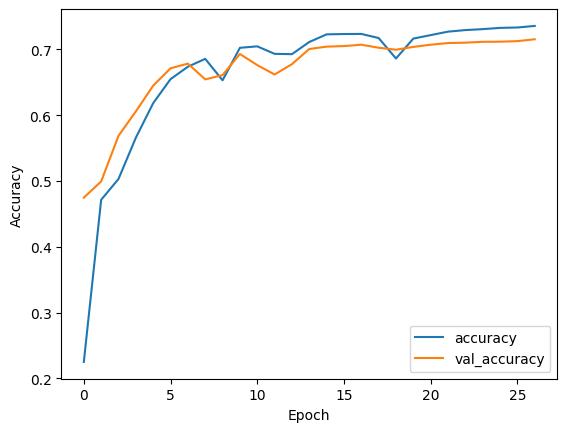

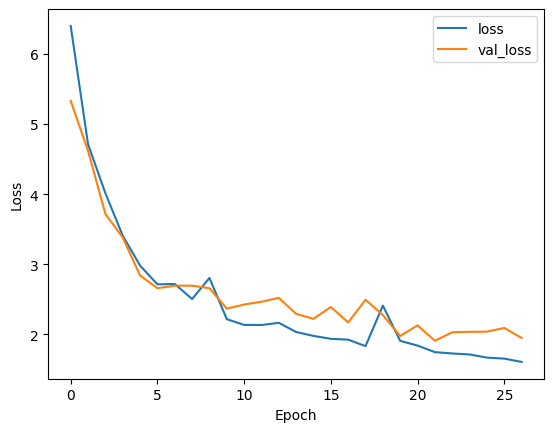

In [67]:
import matplotlib.pyplot as plt

# Visualizamos la historia de entrenamiento
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


## 4 - Inferencia

In [68]:
from tensorflow.keras.models import load_model

# Cargar el modelo entrenado
model = load_model('seq2seq_model.h5')
print("Modelo cargado correctamente.")

Modelo cargado correctamente.


In [69]:
from tensorflow.keras.layers import Add, Dense, Activation, Dot, Concatenate

def attention_layer(encoder_outputs, decoder_hidden_state):
    score = Dot(axes=[2, 2])([encoder_outputs, decoder_hidden_state])
    weights = Activation('softmax')(score)
    context_vector = Dot(axes=[2, 1])([weights, encoder_outputs])
    return context_vector


In [70]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
import numpy as np

# Configurar el modelo Encoder
encoder_model = Model(encoder_inputs, encoder_states)

# Modelo solo decoder (para realizar inferencia)
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [71]:
# Verificar los índices de <sos> y <eos> en el vocabulario de salida
sos_index = word2idx_output.get('<sos>')
eos_index = word2idx_output.get('<eos>')

print("Index de <sos>:", sos_index)
print("Index de <eos>:", eos_index)

# Si alguno de estos índices no es encontrado, puede indicar un problema en la tokenización
if sos_index is None:
    print("El índice <sos> no se encontró en el vocabulario de salida.")
if eos_index is None:
    print("El índice <eos> no se encontró en el vocabulario de salida.")


Index de <sos>: 813
Index de <eos>: 1


In [74]:
# Invertir el diccionario word2idx_output para obtener idx2word_target
idx2word_input = {v:k for k, v in word2idx_input.items()}
idx2word_target = {v:k for k, v in word2idx_output.items()}

In [75]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_output['<sos>']
    eos = word2idx_output['<eos>']
    output_sentence = []
    for _ in range(max_output_len_seq):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.random.choice(range(output_tokens.shape[-1]), p=output_tokens[0, 0, :])
        if eos == idx:
            break
        word = idx2word_target.get(idx, '')
        output_sentence.append(word)
        states_value = [h, c]
        target_seq[0, 0] = idx
    return ' '.join(output_sentence)


In [76]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
answer = decode_sequence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', answer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
-
Input: hey man
Response: i do not in a of illl   intensive


In [79]:
input_text = "What is your favorite color?"
input_text_cleaned = clean_text(input_text)
input_seq = input_tokenizer.texts_to_sequences([input_text_cleaned])
input_seq = pad_sequences(input_seq, maxlen=max_input_len_seq, padding='post')

decoded_sentence = decode_sequence(input_seq)
print("Respuesta del chatbot:", decoded_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Respuesta del chatbot: reading


In [ ]:
input_text = "Hello, how are you?"
input_text_cleaned = clean_text(input_text)
input_seq = input_tokenizer.texts_to_sequences([input_text_cleaned])
input_seq = pad_sequences(input_seq, maxlen=max_input_len_seq, padding='post')

decoded_sentence = decode_sequence(input_seq)
print("Respuesta del chatbot:", decoded_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Respuesta del chatbot: hello how are you


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━

In [81]:
import gradio as gr

def chatbot_response(input_text):
    # Preprocesar la entrada
    input_text_cleaned = clean_text(input_text)
    input_seq = input_tokenizer.texts_to_sequences([input_text_cleaned])
    input_seq = pad_sequences(input_seq, maxlen=max_input_len_seq, padding='post')

    decoded_sentence = decode_sequence(input_seq)
    return decoded_sentence

iface = gr.Interface(
    fn=chatbot_response,
    inputs="text",
    outputs="text",
    theme='soft',
    title="Chatbot Seq2Seq",
    description="Hablá con el chatbot entrenado usando un modelo secuencia a secuencia!"
)

iface.launch()


Running on local URL:  http://127.0.0.1:7866

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


![image.png](../img/image-3.png)

![img2](../img/image-4.png)

## Conclusión

El modelo actual ha demostrado la capacidad de generar respuestas que son contextual y semánticamente correctas para las preguntas de prueba. Hay varios casos para mejorar la precisión y la calidad de las respuestas generadas. A futuro se podría impplementar algun mecanismo de atención y ampliar las capas de LSTM, ampliar el conjunto de datos, etc.